# Multitask GP Regression

## Introduction

This notebook demonstrates how to perform standard (Kronecker) multitask regression.

This differs from the [hadamard multitask example](./Hadamard_Multitask_GP_Regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Kronecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

\begin{equation*}
  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
\end{equation*}

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a special kernel - the `IndexKernel` - which is a lookup table containing inter-task covariance.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Set up the model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Simple_GP_Regression/Simple_GP_Regression.ipynb).

The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a ScaleKernel, since the IndexKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

## Train the model hyperparameters


In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 123.332
Iter 2/50 - Loss: 118.961
Iter 3/50 - Loss: 115.129
Iter 4/50 - Loss: 111.310
Iter 5/50 - Loss: 106.174
Iter 6/50 - Loss: 101.045
Iter 7/50 - Loss: 95.742
Iter 8/50 - Loss: 93.703
Iter 9/50 - Loss: 90.743
Iter 10/50 - Loss: 84.035
Iter 11/50 - Loss: 81.785
Iter 12/50 - Loss: 76.441
Iter 13/50 - Loss: 75.021
Iter 14/50 - Loss: 68.071
Iter 15/50 - Loss: 63.373
Iter 16/50 - Loss: 59.795
Iter 17/50 - Loss: 56.620
Iter 18/50 - Loss: 53.260
Iter 19/50 - Loss: 51.640
Iter 20/50 - Loss: 45.770
Iter 21/50 - Loss: 42.642
Iter 22/50 - Loss: 35.249
Iter 23/50 - Loss: 33.211
Iter 24/50 - Loss: 29.515
Iter 25/50 - Loss: 25.548
Iter 26/50 - Loss: 22.750
Iter 27/50 - Loss: 23.326
Iter 28/50 - Loss: 14.766
Iter 29/50 - Loss: 12.900
Iter 30/50 - Loss: 8.891
Iter 31/50 - Loss: 6.846
Iter 32/50 - Loss: 2.884
Iter 33/50 - Loss: 1.887
Iter 34/50 - Loss: 1.058
Iter 35/50 - Loss: -3.529
Iter 36/50 - Loss: -1.517
Iter 37/50 - Loss: -3.614
Iter 38/50 - Loss: -0.676
Iter 39/50 - Loss: -

## Make predictions with the model

torch.Size([102, 102]) torch.Size([102, 200])


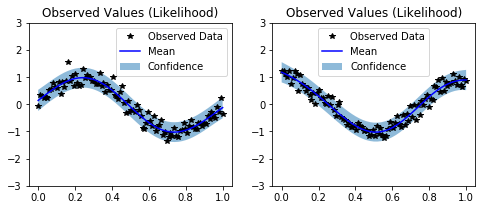

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None